# Phase space tomography

Primer for using phase space tomography tool

In [5]:
%load_ext autoreload
from preprocess import Preprocess
import numpy as np
import h5py
import matplotlib.pyplot as plt
from tomo_plot import Plot
from reconstruct import Reconstruct
import utils
import pickle
plt.rcParams['image.cmap'] = 'jet'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import sinograms measured in AWAKE. 

In [7]:

with open('my_sinox', 'rb') as f:
    data = pickle.load(f)

projectionsx = data['sinogram']
ksx = data['ks']

with open('my_sinoy', 'rb') as f:
    data = pickle.load(f)

projectionsy = data['sinogram']
ksy = data['ks']

Now it is time to preprocess the data to make them ready for tomography

In [8]:

processx = Preprocess(projectionsx, ksx, plane='x', norm=[0.4, 0.6])
processy = Preprocess(projectionsy, ksy, plane='y', norm=[0.4, 0.6])


the process instance is used as input for reconstruction

In [9]:
%autoreload
recx = Reconstruct(processx)
recy = Reconstruct(processy)

dist_x = recx.MLEM(100)
dist_y = recy.MLEM(100)

c:\Users\vbencini\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


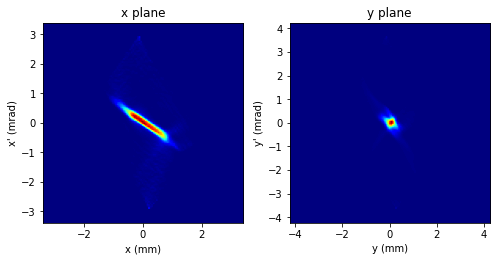

(<Figure size 504x576 with 2 Axes>,
 array([ <AxesSubplot:title={'center':'x plane'}, xlabel='x (mm)', ylabel="x' (mrad)">,
        <AxesSubplot:title={'center':'y plane'}, xlabel='y (mm)', ylabel="y' (mrad)">], dtype=object))

In [6]:
%autoreload
pl = Plot(processx, processy, dist_x, dist_y)
pl.plot_reconstructed()

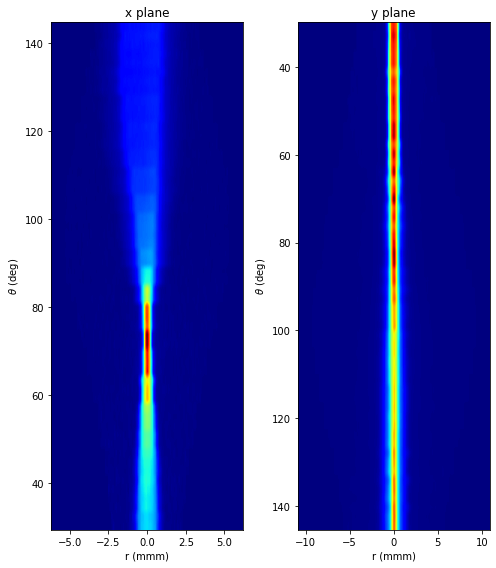

(<Figure size 504x576 with 2 Axes>,
 array([ <AxesSubplot:title={'center':'x plane'}, xlabel='r (mmm)', ylabel='$\\theta$ (deg)'>,
        <AxesSubplot:title={'center':'y plane'}, xlabel='r (mmm)', ylabel='$\\theta$ (deg)'>], dtype=object))

In [8]:
# Plot scaled sinograms

pl.plot_sino_scale()

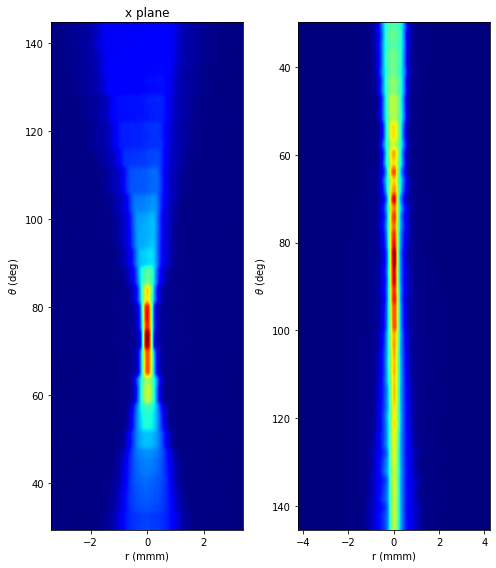

(<Figure size 504x576 with 2 Axes>,
 array([ <AxesSubplot:title={'center':'x plane'}, xlabel='r (mmm)', ylabel='$\\theta$ (deg)'>,
        <AxesSubplot:xlabel='r (mmm)', ylabel='$\\theta$ (deg)'>], dtype=object))

In [2]:

from track import Track
k=10
tr = Track()
tr.add_quadrupole(0.0708, k, 'x')
tr.add_drift(0.831693)
tr.create_sequence()


array([[ 0.39110975,  0.88114503],
       [-0.70209989,  0.97504132]])